In [171]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [172]:
torch.cuda.is_available()

True

In [173]:
# Enforcing GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
# Loading file paths
train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'
#train_path = f'E:/CMAPSS/data/train_FD00X.txt'
#test_path = f'E:/CMAPSS/data/test_FD00X.txt'
#RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'

labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors

In [175]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    dtype=np.float32))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    dtype=np.float32))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [176]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

# Adding RUL columns to the training dataframes dataframe
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


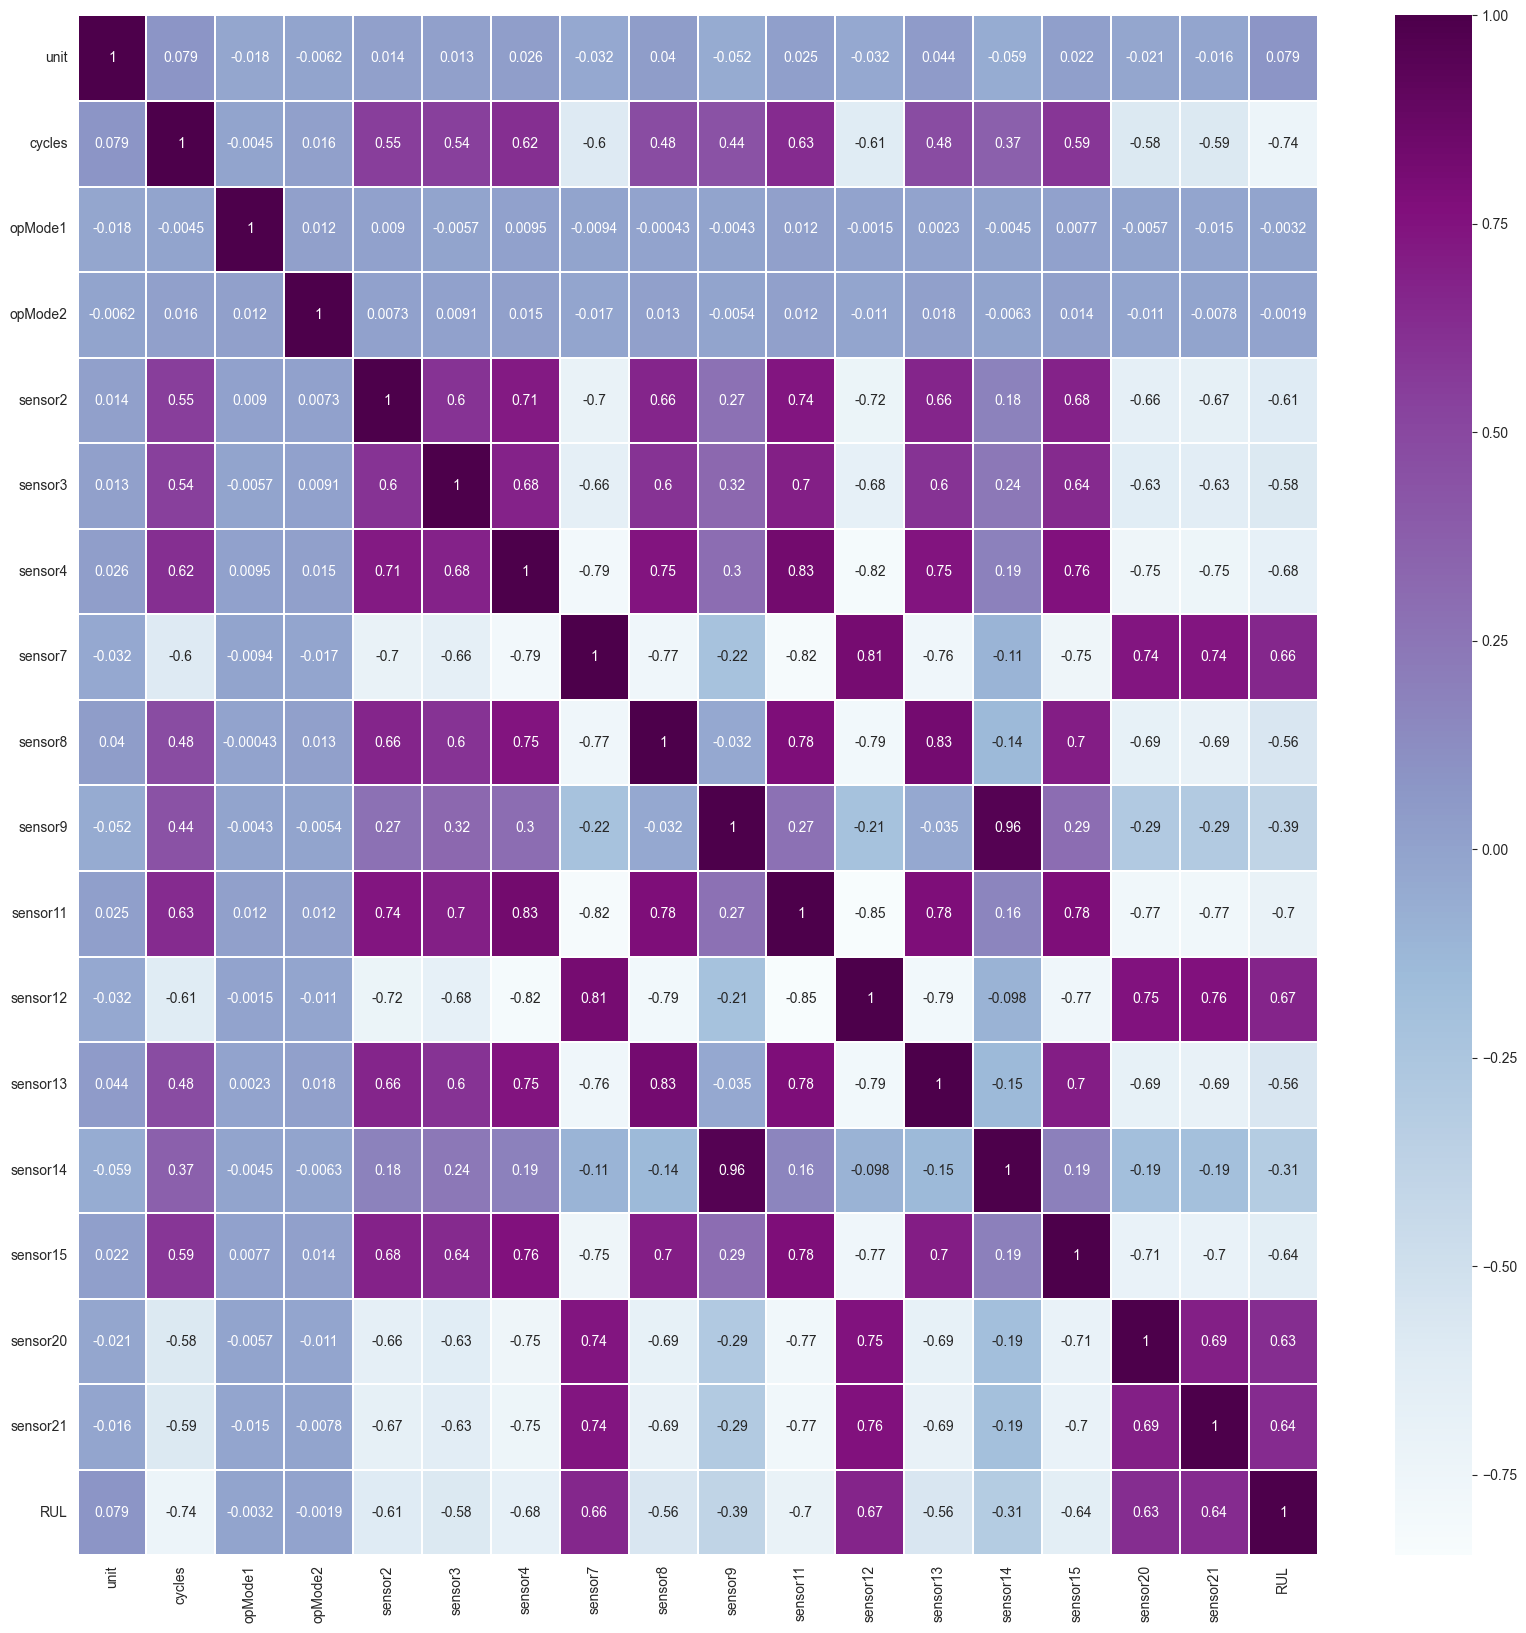

In [177]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [178]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [179]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])

In [180]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [181]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [604]:
sequence_length = 13
trajectory = 0  # see readme file
batch_size = 128

In [183]:
FD001_train = train_data[trajectory]
FD001_test = test_data[trajectory]
FD001_truth = RUL_data[trajectory]

In [605]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [606]:
feature_count = a.shape[2]
out_dim = 1  # output dimension (1 RUL value)

In [607]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.25, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

In [608]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [385]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [189]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [609]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim):
        super(DamagePropagationLSTM, self).__init__()
        # Stacked convolutional block
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=feature_count, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )
        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(num_features=128) 
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(in_features=64, out_features=out_dim)
        self.activation2 = nn.LeakyReLU()

    def forward(self, x):
        #x = self.conv1(x.transpose(1, 2)).transpose(1, 2)
        #x = self.maxpool1d(x)
        #x = self.flatten(x)
        #x = self.dense1(x)
       #x = self.activation1(x)
        
        x = self.cnn(x.transpose(1, 2)).transpose(1, 2)
        x, _ = self.lstm1(x)
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x
       
   

In [610]:
# training function
def train_model(model, criterion, optimizer, 
                scheduler, train_loader, val_loader, 
                num_epochs=60, patience=20, destination='unnamed_model.pt'):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * data.size(0)

        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), destination)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses



In [611]:
Model = DamagePropagationLSTM(feature_count, out_dim).to(device)

In [616]:
# Loss criterion
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.0005, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

In [617]:
root_path = os.getcwd()
model_directory = 'models'
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
model_number = 12
model_path = root_path + os.path.join(f'\{model_directory}', f'lstm_{model_number}.pt')
model_path

'D:\\DataScience\\CMAPSS\\main\\code\\models\\lstm_12.pt'

In [628]:
epochs = 60
model1 = train_model(Model, criterion, optimizer, scheduler,
                     train_loader, val_loader, num_epochs=epochs, 
                     patience=15, destination=model_path)

Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070 Ti Laptop GPU...
Epoch 1/60, Training Loss: 365.1038, Validation Loss: 285.1996
Epoch 2/60, Training Loss: 348.4342, Validation Loss: 278.0124
Epoch 3/60, Training Loss: 347.7796, Validation Loss: 305.4615
Epoch 4/60, Training Loss: 349.7336, Validation Loss: 316.3011
Epoch 5/60, Training Loss: 344.9735, Validation Loss: 264.7051
Epoch 6/60, Training Loss: 341.2865, Validation Loss: 266.9190
Epoch 7/60, Training Loss: 336.4859, Validation Loss: 267.9745
Epoch 8/60, Training Loss: 334.8153, Validation Loss: 266.3266
Epoch 9/60, Training Loss: 327.7542, Validation Loss: 252.2537
Epoch 10/60, Training Loss: 328.2036, Validation Loss: 253.3201
Epoch 11/60, Training Loss: 329.4109, Validation Loss: 249.4747
Epoch 12/60, Training Loss: 319.6874, Validation Loss: 260.8677
Epoch 13/60, Training Loss: 321.7464, Validation Loss: 245.9753
Epoch 14/60, Training Loss: 325.0617, Validation Loss: 251.0343
Epoch 15/60, Train

In [629]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (cnn): Sequential(
    (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(64, 128, batch_first=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
)

In [630]:
def evaluation_metrics(ground_truth, prediction):
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    return None


def loss_graphs(model):
    # expects a tuple of training and validation losses
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

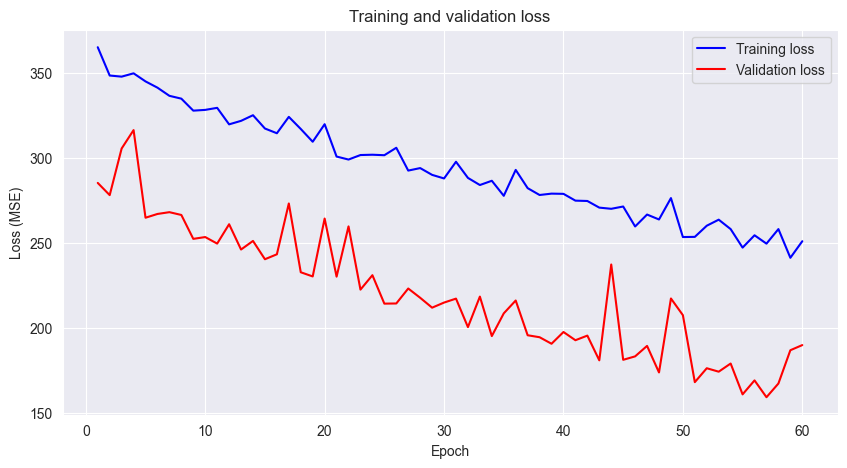

In [631]:
loss_graphs(model1)


### Model evaluation on validation data

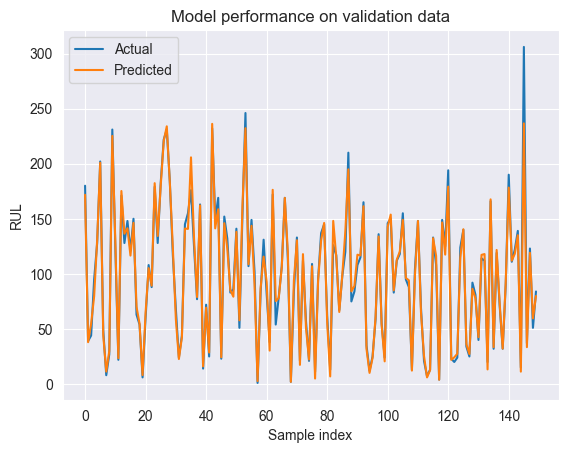

In [632]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).cpu()

# Plotting
plt.plot(y_train[0:150], label='Actual')
plt.plot(y_train_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [633]:
# Validation data test metrics
evaluation_metrics(y_train, y_train_pred)

Mean squared error: 127.05139923095703
Root mean squared error: 11.271707534790039
R2 score: 0.9708306193351746
Mean absolute error: 6.241481304168701


# Preparing test data

In [634]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)

In [635]:
x_test.shape, FD001_test.shape

((13084, 13, 14), (13096, 15))

Looking at the dimensions of the test data tensor and the test data dataframe, one can see that the relation between the 0th dimensions is sequence_length - 1. (13096 - 13082 = 14, which happens to be our sequence_length of 15, minus 1. Let (sequence_length - 1) be referenced as delta from hereon.
This is most likely the source of error which has skewed the model's predictions where the predicted values are shifted by an amount delta. This explains why the model follows the trend but always looks like it's offset by some fixed value.\
The code functions as intended, but the issue is using create_training_sequence() to prepare test data.

We can still evaluate model accuracy sufficiently even after removing the first (sequence_length - 1) values from the RUL vector.

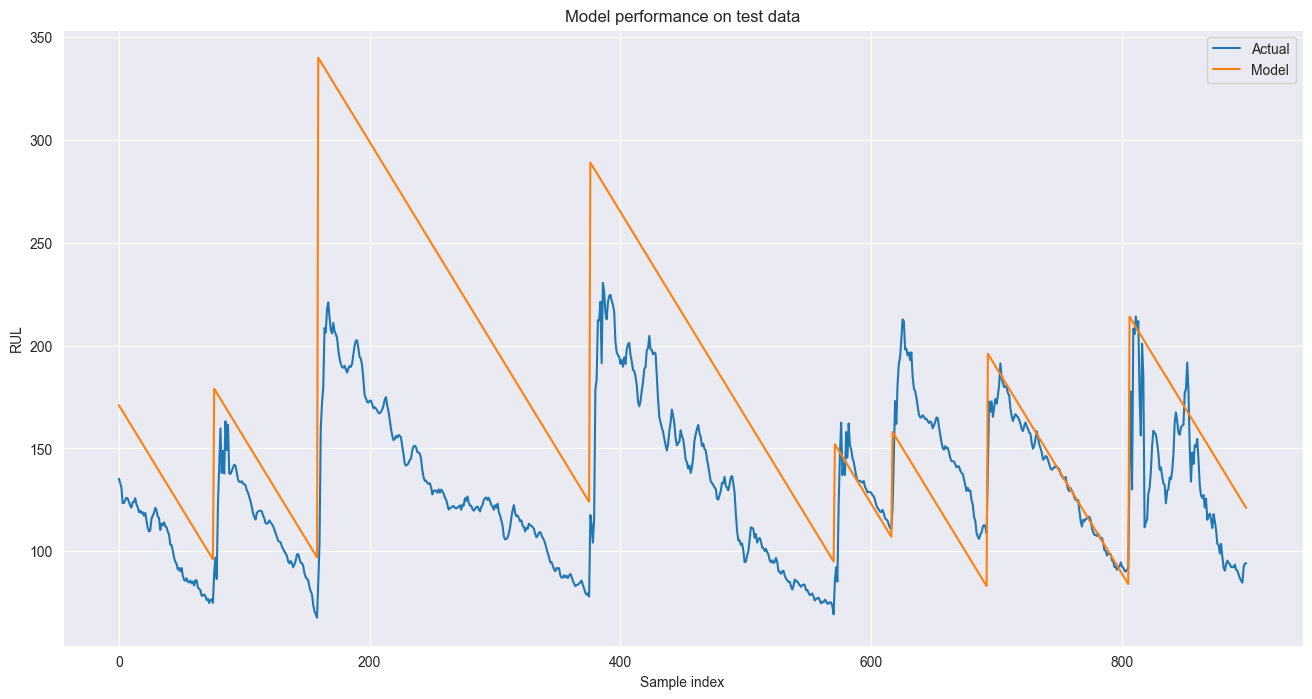

In [636]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)
start_idx = 1000
end_idx = 1900
truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(y_test_pred[start_idx:end_idx], label='Actual')
plt.plot(truncated_subset, label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()


In [637]:
# Test data evaluation
evaluation_metrics(truncated_ground_truth, y_test_pred)


Mean squared error: 2796.178466796875
Root mean squared error: 52.878902435302734
R2 score: 0.19685745239257812
Mean absolute error: 40.583980560302734


Exploring the uses of dropout layers in recurrent architectures and how to optimise them.
[1] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7333848&tag=1
Convolutional layer adjustment
[2] https://arxiv.org/pdf/1603.07285v1